In [1]:
# import libraries
import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#!pip install xgboost
import xgboost as xgb

In [2]:
# read csv to dataframe
df_tabA = pd.read_csv('table_A_conversions.csv')
df_tabA.head()

,Conv_Date,Revenue,User_ID,Conv_ID
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735


Agenda: lets write a info function for sanity check

In [3]:
def info(x):
    '''
    return information about dataframe
    '''
    decoration = "-_-"
    print("df.info() \n") 
    x.info() 
    print("\n {} \n".format((decoration*20))) 
    print("df.describe() \n\n", x.describe().round(2))
    print("\n {} \n".format((decoration*20))) 
    print("df.shape: {}".format(x.shape))
    print("\n {} \n".format((decoration*20)))
    print("df.isna().sum()\n\n{}".format(x.isna().sum()))
    print("\n {} \n".format((decoration*20)))
    print("df.nunique()\n\n{}".format(x.nunique()))
    return

In [4]:
info(df_tabA)

df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79643 entries, 0 to 79642
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Conv_Date  79643 non-null  object 
 1   Revenue    79643 non-null  float64
 2   User_ID    77347 non-null  object 
 3   Conv_ID    79643 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.4+ MB

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.describe() 

         Revenue
count  79643.00
mean     181.70
std      109.24
min       20.00
25%      114.23
50%      158.47
75%      217.59
max     4596.48

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.shape: (79643, 4)

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.isna().sum()

Conv_Date       0
Revenue         0
User_ID      2296
Conv_ID         0
dtype: int64

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.nunique()

Conv_Date      389
Revenue    

In [5]:
# one hot encoding
# Change Conv_Date from object to datetime
df_tabA['Conv_Date'] = pd.to_datetime(df_tabA['Conv_Date'])
# dataframe of unique customers
df_user = pd.DataFrame(df_tabA['User_ID'].unique())
# dropping the null User_IDs
df_user.dropna(inplace=True)
df_user.columns = ['User_ID']
df_user.head()

,User_ID
0,5094298f068196c5349d43847de5afc9125cf989
2,433fdf385e33176cf9b0d67ecf383aa928fa261c
3,59853624ad85789cc5c865405e741c612da334da
4,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222
5,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e


# Recency

In [6]:
# lets figure out the latest date of each customer being latest converted
df_max_conversion = df_tabA.groupby('User_ID').Conv_Date.max().reset_index()
# lets assume that today is the day I took these data out of my inventory and some of the customers has converted today
df_max_conversion['Recency'] = (df_max_conversion['Conv_Date'].max() - df_max_conversion['Conv_Date']).dt.days
df_user = pd.merge(df_user, df_max_conversion[['User_ID','Recency']], on='User_ID')
df_user.head()

,User_ID,Recency
0,5094298f068196c5349d43847de5afc9125cf989,37
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41
2,59853624ad85789cc5c865405e741c612da334da,233
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287


In [7]:
info(df_user)

df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55352 entries, 0 to 55351
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   User_ID  55352 non-null  object
 1   Recency  55352 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.describe() 

         Recency
count  55352.00
mean     174.31
std      111.43
min        0.00
25%       78.00
50%      170.00
75%      265.00
max      390.00

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.shape: (55352, 2)

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.isna().sum()

User_ID    0
Recency    0
dtype: int64

 -_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_--_- 

df.nunique()

User_ID    55352
Recency      389
dtype: int64


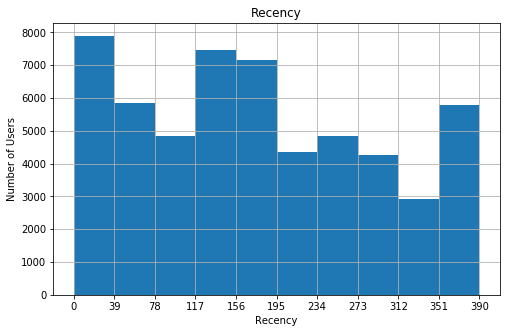

In [8]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_user['Recency'])

df_user['Recency'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Recency') # add a title to the histogram
plt.ylabel('Number of Users') # add y-label
plt.xlabel('Recency') # add x-label
plt.grid()
plt.show()

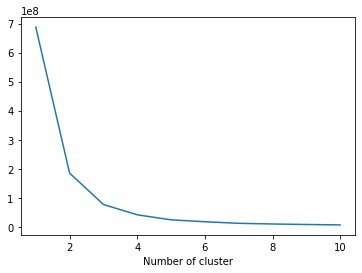

In [9]:
# Elbow method to determine n_cluster
cost=[]
df_recency = df_user[['Recency']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    cost.append(kmeans.inertia_) 
plt.plot(range(1, 11), cost)
plt.xlabel("Number of cluster")
plt.show()

Elbow is forming at 3. So lets consider n_cluster = 3

In [10]:
# Kmeans for RecencyCluster
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

df_user.head()

,User_ID,Recency,RecencyCluster
0,5094298f068196c5349d43847de5afc9125cf989,37,2
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2
2,59853624ad85789cc5c865405e741c612da334da,233,1
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0


In [11]:
 df_user.groupby('RecencyCluster')['User_ID'].count()

RecencyCluster
0    16163
1    21097
2    18092
Name: User_ID, dtype: int64

In [12]:
df_recency = df_user.copy()
df_recency_grpby = df_recency.groupby(['RecencyCluster']).mean()
df_recency_grpby

,Recency
RecencyCluster,
0,317.177380
1,171.634877
2,49.789299


In [13]:
def order_cluster(df,sort_by_colname, index_name):
    '''
    returns clusters in ascending order
    '''
    df_new = df.sort_values(by=sort_by_colname).reset_index(index_name)
    df_new.drop([index_name],axis=1, inplace=True)
    df_new.index.name = index_name
    return df_new

In [14]:
df_recency_grpby = order_cluster(df_recency_grpby, 'Recency', 'RecencyCluster')
df_recency_grpby

,Recency
RecencyCluster,
0,49.789299
1,171.634877
2,317.177380


0 is the most recent users and 2 is most inactive users

# Frequency

In [15]:
df_tabA.head()

,Conv_Date,Revenue,User_ID,Conv_ID
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735


In [16]:
# get conv date count for each user and create a dataframe with it
df_frequency = df_tabA.groupby('User_ID').Conv_Date.count().reset_index()
df_frequency.columns = ['User_ID','Frequency']

df_merged = pd.merge(df_recency, df_frequency, on='User_ID')
df_merged.head()

,User_ID,Recency,RecencyCluster,Frequency
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4
2,59853624ad85789cc5c865405e741c612da334da,233,1,4
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3


In [17]:
# Kmeans for FrequencyCluster
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merged[['Frequency']])
df_merged['FrequencyCluster'] = kmeans.predict(df_merged[['Frequency']])

df_merged.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0


In [18]:
df_merged['Frequency'].describe()

count    55352.000000
mean         1.397366
std          1.373087
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        111.000000
Name: Frequency, dtype: float64

111 is an outlier

In [19]:
df_merged.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4083.0,3.861866,1.017497,3.0,3.0,4.0,5.0,6.0
1,50535.0,1.081191,0.273131,1.0,1.0,1.0,1.0,2.0
2,734.0,9.456403,5.069517,7.0,7.0,8.0,10.0,111.0


In [20]:
df_frequency_grpby = df_merged.groupby(['FrequencyCluster'])['Frequency'].mean().to_frame()
df_frequency_grpby = order_cluster(df_frequency_grpby, 'Frequency', 'FrequencyCluster')
df_frequency_grpby

,Frequency
FrequencyCluster,
0,1.081191
1,3.861866
2,9.456403


# Moneytary Value

In [21]:
df_tabA.head()

,Conv_Date,Revenue,User_ID,Conv_ID
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735


In [22]:
#get order counts for each user and create a dataframe with it
df_revenue = df_tabA.groupby('User_ID').Revenue.sum().reset_index()
df_revenue.columns = ['User_ID','Revenue']

df_merged = pd.merge(df_merged,df_revenue, on='User_ID')
df_merged.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2,2842.11400
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0,721.64348
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0,2171.12960
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1,40.00000
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0,457.27608


In [23]:
# Kmeans for RevenueCluster
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merged[['Revenue']])
df_merged['RevenueCluster'] = kmeans.predict(df_merged[['Revenue']])

df_merged.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2,2842.11400,2
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0,721.64348,1
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0,2171.12960,2
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1,40.00000,0
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0,457.27608,0


In [24]:
df_merged['Revenue'].describe()

count    55352.000000
mean       254.433006
std        346.569504
min         24.646960
25%        114.900000
50%        167.160000
75%        258.046000
max      29117.303120
Name: Revenue, dtype: float64

29117 is an outlier

In [25]:
#calculate overall score and use mean() to see details
df_rfm = df_merged.copy()
df_rfm['AggScore'] = df_merged['RecencyCluster'] + df_merged['FrequencyCluster'] + df_merged['RevenueCluster']

df_rfm.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2,2842.11400,2,6
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0,721.64348,1,3
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0,2171.12960,2,3
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1,40.00000,0,1
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0,457.27608,0,0


In [41]:
df_agg = df_rfm.groupby('AggScore')[['Recency','Frequency','Revenue']].mean().reset_index()
df_agg['Segment'] = 'Low-Value'
df_agg.loc[df_agg['AggScore']>2,'Segment'] = 'Mid-Value' 
df_agg.loc[df_agg['AggScore']>4,'Segment'] = 'High-Value' 
df_agg

,AggScore,Recency,Frequency,Revenue,Segment
0,0,306.131429,3.085714,393.451569,Low-Value
1,1,312.635035,1.160562,191.260090,Low-Value
2,2,171.864322,1.273990,223.390305,Low-Value
3,3,53.813560,1.386276,259.371820,Mid-Value
4,4,68.262712,3.258475,1042.636095,Mid-Value
5,5,49.862360,8.154494,1468.326032,High-Value
6,6,33.441860,11.342193,2749.143367,High-Value


In [27]:
# assign value to users 
df_rfm['Segment'] = 'Low-Value'
df_rfm.loc[df_rfm['AggScore']>2,'Segment'] = 'Mid-Value' 
df_rfm.loc[df_rfm['AggScore']>4,'Segment'] = 'High-Value' 
df_rfm.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2,2842.11400,2,6,High-Value
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0,721.64348,1,3,Mid-Value
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0,2171.12960,2,3,Mid-Value
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1,40.00000,0,1,Low-Value
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0,457.27608,0,0,Low-Value


# Lifetime Value (LTV) Analysis

Lifetime value for a user is (total gross revenue - Total cost). Since, df_tabA has only Revenue available, I will not consider cost for LTV analysis.

In [28]:
# Previously computed RFM Cluster dataframe
df_rfm.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment
0,5094298f068196c5349d43847de5afc9125cf989,37,2,15,2,2842.11400,2,6,High-Value
1,433fdf385e33176cf9b0d67ecf383aa928fa261c,41,2,4,0,721.64348,1,3,Mid-Value
2,59853624ad85789cc5c865405e741c612da334da,233,1,4,0,2171.12960,2,3,Mid-Value
3,8b14ce0002a2a7adbe61c6386dd5b8b8a8435222,377,0,1,1,40.00000,0,1,Low-Value
4,b7d38ff2747f3ebe3c6b4e6169dbb7c761177a2e,287,0,3,0,457.27608,0,0,Low-Value


In [29]:
# df with Conv_Data and Revenue
df_tabA.head()

,Conv_Date,Revenue,User_ID,Conv_ID
0,2017-03-06,47.00000,5094298f068196c5349d43847de5afc9125cf989,881152bb20f9b73daafb99d77714f38ac702629c
1,2017-03-02,98.00004,NaN,faf5c1181ea84a32237dff45ca201d2c28f19d7b
2,2017-03-02,180.35300,NaN,b0e58a88459ece1b585ca22c93e633dc56273b83
3,2017-03-23,201.94104,433fdf385e33176cf9b0d67ecf383aa928fa261c,f0e6b7de22332c7b18c024e550bb1d860130cdf1
4,2017-03-03,197.47008,NaN,966568c7c859480c79b212520d20a51e735fd735


To evaluate lifetime value I require, get the latest conversion date for each user.

In [30]:
# Latest Conversion date groupby User
df1 = df_tabA.groupby(['User_ID'])['Conv_Date'].max().reset_index()
# lets merge df1 with RFM Cluster dataframe
df2 = pd.merge(df1, df_rfm, on='User_ID')
df2.head()

,User_ID,Conv_Date,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment
0,00003ce67d6b73b2d49f4036f60cb73385a9c96e,2017-11-01,145,1,1,1,153.840,0,2,Low-Value
1,0003509d64606735e66a3d32f2a1a084f613ee4b,2017-12-28,88,2,2,1,245.632,0,3,Mid-Value
2,00035f943a8a8e176fdd5a44059b38dcc0c73f5a,2018-02-17,37,2,2,1,833.164,1,4,Mid-Value
3,0003f10010cd3dadcb7182ed7b0abf5166393e91,2017-06-13,286,0,1,1,121.808,0,1,Low-Value
4,0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,2018-02-27,27,2,1,1,108.720,0,3,Mid-Value


In [31]:
df2.shape

(55352, 10)

The period for LTV depends on the business requirement. Lets compute for 3 months. Later down the line, compute for 6,9 or 12 months for comparison.  

In [32]:
# Create df with filtered data of latest three months
df_three = df2[(df2.Conv_Date < datetime.datetime(2018,3,26)) & (df2.Conv_Date >= datetime.datetime(2018,1,1))].reset_index(drop=True)
df_three.head()

,User_ID,Conv_Date,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment
0,00035f943a8a8e176fdd5a44059b38dcc0c73f5a,2018-02-17,37,2,2,1,833.164,1,4,Mid-Value
1,0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,2018-02-27,27,2,1,1,108.720,0,3,Mid-Value
2,00062ca12fb12401ee7f16bd9afd21b8e45cf387,2018-01-16,69,2,1,1,61.476,0,3,Mid-Value
3,0008750fb842d6eb73f905c259d2a210a64542cc,2018-03-09,17,2,1,1,151.272,0,3,Mid-Value
4,001b34807c20cc3d4391564d66f53e1fae118b36,2018-03-13,13,2,1,1,134.504,0,3,Mid-Value


In [33]:
df_three['Revenue'].describe()

count    14701.000000
mean       336.426610
std        540.632572
min         27.532000
25%        118.832000
50%        178.472000
75%        305.700000
max      29117.303120
Name: Revenue, dtype: float64

29117 is outlier

In [34]:
# filter out outlier
df_three = df_three[df_three['Revenue']<df_three['Revenue'].quantile(0.99)]
# kmeans for LTVCluster
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_three[['Revenue']])
# Create LTVCluster column based on kmeans
df_three['LTVCluster'] = kmeans.predict(df_three[['Revenue']])
df_three.head()

,User_ID,Conv_Date,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment,LTVCluster
0,00035f943a8a8e176fdd5a44059b38dcc0c73f5a,2018-02-17,37,2,2,1,833.164,1,4,Mid-Value,1
1,0003fc733e4ff3bfb295f2c10c7077fb0763ebcc,2018-02-27,27,2,1,1,108.720,0,3,Mid-Value,0
2,00062ca12fb12401ee7f16bd9afd21b8e45cf387,2018-01-16,69,2,1,1,61.476,0,3,Mid-Value,0
3,0008750fb842d6eb73f905c259d2a210a64542cc,2018-03-09,17,2,1,1,151.272,0,3,Mid-Value,0
4,001b34807c20cc3d4391564d66f53e1fae118b36,2018-03-13,13,2,1,1,134.504,0,3,Mid-Value,0


In [35]:
df_three.sort_values(by=['LTVCluster'], ascending=False).head()

,User_ID,Conv_Date,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,Segment,LTVCluster
12728,dd0cf6e0654bdf505c395c2ded1487c82b6f3c9e,2018-03-08,18,2,11,2,2034.45904,2,6,High-Value,2
9212,9eed9f5dac927a75950d81a8968f3dcc8d95c85f,2018-02-18,36,2,6,0,1414.76000,1,3,Mid-Value,2
2049,23405f612aac7753c66ea133a669f59fda1f49b4,2018-03-08,18,2,10,2,1433.17200,1,5,High-Value,2
12983,e147332593bd89a404aeef2cfb76fc2bf9b28b75,2018-02-25,29,2,9,2,1297.46000,1,5,High-Value,2
2029,22cc2df1701eb123d8316990f971d591a8e994e4,2018-01-15,70,2,12,2,2146.17728,2,6,High-Value,2


In [36]:
df_three.groupby('LTVCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,12144.0,173.577785,85.258566,27.53200,111.504,152.80000,216.658,448.496
1,1729.0,722.877460,198.634229,449.10400,552.484,682.76000,874.496,1143.600
2,680.0,1565.698921,317.968744,1145.64912,1293.533,1506.00388,1799.396,2312.612


In [37]:
df = df_three.copy()
# One hot encoding
df.drop(['Conv_Date', 'User_ID'],axis=1, inplace=True)
df.index.name = 'User_ID'
df.reset_index('User_ID', inplace=True)
df_final = pd.get_dummies(df)
df_final.head()

,User_ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,AggScore,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,0,37,2,2,1,833.164,1,4,1,0,0,1
1,1,27,2,1,1,108.720,0,3,0,0,0,1
2,2,69,2,1,1,61.476,0,3,0,0,0,1
3,3,17,2,1,1,151.272,0,3,0,0,0,1
4,4,13,2,1,1,134.504,0,3,0,0,0,1


In [38]:
# dependent variables
X = df_final.drop(['LTVCluster','Revenue'],axis=1)
# indetenpent variable
y = df_final['LTVCluster']
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=50)

In [39]:
# Train Model and Predict 
model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       602
           1       0.82      0.81      0.82        90
           2       0.88      0.64      0.74        36

    accuracy                           0.95       728
   macro avg       0.89      0.82      0.85       728
weighted avg       0.95      0.95      0.95       728

